In [1]:
from data_loader import load_and_prepare_data
from credit_models import modelValuation
from pytorch_tabnet.tab_model import TabNetClassifier
from tuner import tune_model

c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
(X_train, X_test, Y_train, Y_test), cat_idxs, cat_dims = load_and_prepare_data('tabnet')

# Get best hyperparameters from tuning
best_params = tune_model("tabnet", X_train, Y_train, n_trials=10, n_splits=2 , cat_idxs= cat_idxs , cat_dims= cat_dims)

# Prepare required fields from best_params
tabnet_params = {
    "n_d": best_params["n_d"],
    "n_a": best_params["n_a"],
    "n_steps": best_params["n_steps"],
    "gamma": best_params["gamma"],
    "lambda_sparse": best_params["lambda_sparse"],
    "optimizer_params": best_params["optimizer_params"],
    "mask_type": best_params["mask_type"],
    "verbose": 0,
    "device_name": "auto",
    "cat_idxs": cat_idxs,
    "cat_dims": cat_dims,
    "cat_emb_dim": 1  # Can be tuned later if needed
}

# Train final model
model = TabNetClassifier(**tabnet_params)
model.fit(
    X_train=X_train.values, y_train=Y_train.values,
    eval_set=[(X_test.values, Y_test.values)],
    eval_metric=["auc"],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    weights=1
)

# Predict probabilities
y_proba = model.predict_proba(X_test.values)[:, 1]


[I 2025-06-09 15:58:50,124] A new study created in memory with name: no-name-a16c1a83-5a05-41b7-ac7a-468a5ff2da12
[W 2025-06-09 15:58:58,423] Trial 0 failed with parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 6, 'gamma': 1.3173913778565707, 'lambda_sparse': 5.955834189684319e-05, 'lr': 0.035602801140188614} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "d:\Projects\CreditWorthinessModel\tuner.py", line 135, in objective
    model.fit(
  File "c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py", line 258, in fit
    self._train_epoch(train_dataloader)
  File "c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py", line 489, in _train_epoch
    batch_logs 

KeyboardInterrupt: 


[⚙️ TabNet] Using Best Threshold = 0.2700 (F1 = 0.675, P = 0.528, R = 0.934)

🔍 [TabNet] Classification Report @ Threshold = 0.26998937129974365
                 precision    recall  f1-score   support

Good Credit (0)       0.72      0.17      0.27       500
 Bad Credit (1)       0.53      0.93      0.67       500

       accuracy                           0.55      1000
      macro avg       0.62      0.55      0.47      1000
   weighted avg       0.62      0.55      0.47      1000

🧠 Explanation of Key Metrics:
- Precision (Good Credit): 0.72 → 72% of those predicted as good credit were correct.
- Recall (Good Credit)   : 0.17 → 17% of all actual good credits were correctly identified.
- Precision (Bad Credit) : 0.53 → 53% of those predicted as bad credit were correct.
- Recall (Bad Credit)    : 0.93 → 93% of all actual bad credits were correctly identified.
- Accuracy               : 0.55 → 55% of all predictions were correct.
- ROC-AUC                : 0.64 → Model distinguishes 

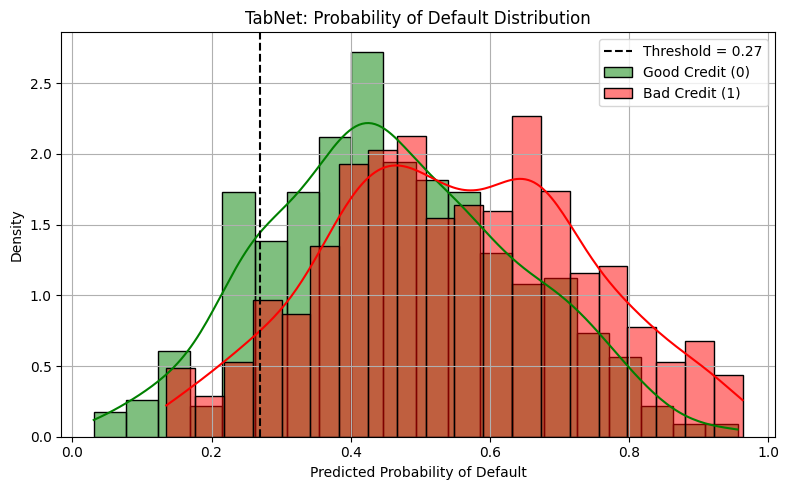

In [3]:
y_pred, chosen_thresh = modelValuation("TabNet", Y_test, y_proba, use_best_threshold=True)


[⚙️ TabNet] Using Default Threshold = 0.5

🔍 [TabNet] Classification Report @ Threshold = 0.5
                 precision    recall  f1-score   support

Good Credit (0)       0.58      0.61      0.60       500
 Bad Credit (1)       0.59      0.57      0.58       500

       accuracy                           0.59      1000
      macro avg       0.59      0.59      0.59      1000
   weighted avg       0.59      0.59      0.59      1000

🧠 Explanation of Key Metrics:
- Precision (Good Credit): 0.58 → 58% of those predicted as good credit were correct.
- Recall (Good Credit)   : 0.61 → 61% of all actual good credits were correctly identified.
- Precision (Bad Credit) : 0.59 → 59% of those predicted as bad credit were correct.
- Recall (Bad Credit)    : 0.57 → 57% of all actual bad credits were correctly identified.
- Accuracy               : 0.59 → 59% of all predictions were correct.
- ROC-AUC                : 0.64 → Model distinguishes good vs. bad credit with 64% confidence.


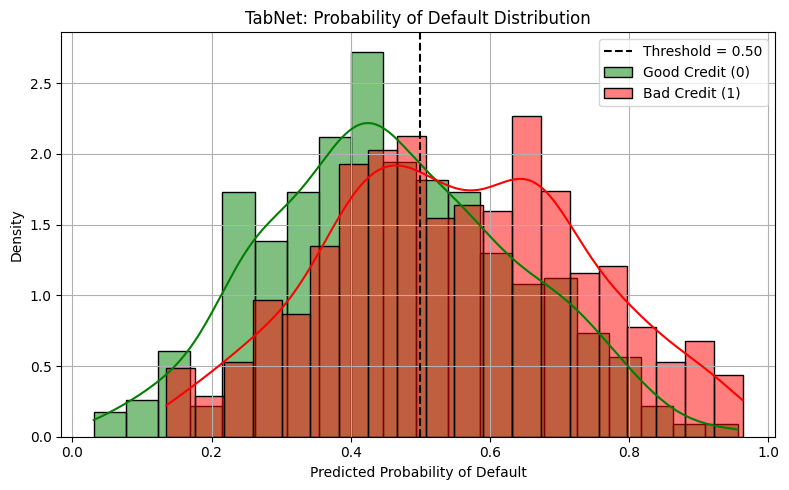

In [4]:
y_pred, chosen_thresh = modelValuation("TabNet", Y_test, y_proba, use_best_threshold=False)

In [5]:
import joblib
joblib.dump(y_proba, "proba_tab.pkl") 

['proba_tab.pkl']